In [1]:
import os
path = '/home/lishenghe/SINTER3D/' 
os.chdir(path)  
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.io import mmread
import sys
from SINTER3D import utils
import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### 参考数据整理 

In [2]:
# # ===== 1. 读取 count 矩阵 =====
# ref_count = mmread(
#     "/home/lishenghe/SINTER3D/data/her2_breast_cancer/Wu_etal_2021_BRCA_scRNASeq/count_matrix_sparse.mtx"
# )
# adata_ref_raw = ad.AnnData(X=ref_count.tocsr().T)

# # ===== 2. 读取 barcodes =====
# barcodes = pd.read_csv(
#     "/home/lishenghe/SINTER3D/data/her2_breast_cancer/Wu_etal_2021_BRCA_scRNASeq/count_matrix_barcodes.tsv",
#     header=None, index_col=0
# )
# barcodes.index = barcodes.index.astype(str).str.strip()

# # ===== 3. 读取基因信息 =====
# features = pd.read_csv(
#     "/home/lishenghe/SINTER3D/data/her2_breast_cancer/Wu_etal_2021_BRCA_scRNASeq/count_matrix_genes.tsv",
#     header=None, index_col=0, sep="\t"
# )
# features.index = features.index.astype(str).str.strip()

# # ===== 4. 读取 meta（第一列是 barcode，改名为 'barcode'）=====
# meta = pd.read_csv(
#     "/home/lishenghe/SINTER3D/data/her2_breast_cancer/Wu_etal_2021_BRCA_scRNASeq/metadata.csv",
#     skiprows=[1]
# )
# meta.rename(columns={meta.columns[0]: "barcode"}, inplace=True)
# meta.index = meta["barcode"].astype(str).str.strip()
# meta.index.name = None

# print("📌 meta 列名:", meta.columns.tolist())
# print(f"📊 barcodes 条数: {len(barcodes)}, meta 条数: {len(meta)}")

# # ===== 5. 给 AnnData 设定细胞索引（去掉索引名int问题）=====
# adata_ref_raw.obs.index = barcodes.index
# adata_ref_raw.obs.index.name = None

# # ===== 6. 找到公共的 barcode，过滤 =====
# common_index = adata_ref_raw.obs.index.intersection(meta.index)
# adata_ref_raw = adata_ref_raw[common_index, :]

# # ===== 7. 合并 meta 信息到 obs（保留原列名）=====
# cols_to_add = ["orig.ident", "celltype_major", "celltype_minor", "celltype_subset", "subtype"]
# adata_ref_raw.obs = adata_ref_raw.obs.join(meta.loc[common_index, cols_to_add])

# adata_ref_raw.obs.rename(columns={"orig.ident": "Patient"}, inplace=True)

# # ===== 8. 设置 var（基因信息）=====
# adata_ref_raw.var.index = features.index
# adata_ref_raw.var.index.name = None

# # ===== 9. 保存前保险：确保列名均为 str =====
# adata_ref_raw.obs.columns = adata_ref_raw.obs.columns.astype(str)
# adata_ref_raw.var.columns = adata_ref_raw.var.columns.astype(str)

# # ===== 10. 保存 =====
# save_path = "/home/lishenghe/SINTER3D/data/her2_breast_cancer/adata_ref_raw.h5ad"
# adata_ref_raw.write(save_path)

# print(f"✅ 最终细胞数: {adata_ref_raw.n_obs} | 基因数: {adata_ref_raw.n_vars}")
#sc参考
adata_ref_raw = ad.read_h5ad("/home/lishenghe/STitch3D-main/data/her2_breast_cancer/adata_ref_raw.h5ad")
adata_ref = adata_ref_raw[adata_ref_raw.obs["subtype"].values.astype(str)=="HER2+", :]

# Delete cycling cells and cell types with less than 50 cells
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling T-cells"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling_Myeloid"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling PVL"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer Cycling"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "B cells Naive"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Endothelial Lymphatic LYVE1"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer LumB SC"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer LumA SC"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer Basal SC"]


In [3]:
# spatial data
patho_anno = pd.read_csv("/home/lishenghe/STitch3D-main/data/her2_breast_cancer/meta/A1_labeled_coordinates.tsv", index_col=0, sep='\t')

adata_st_list_raw = []

for i in range(1, 7):

    st_count = pd.read_csv("/home/lishenghe/STitch3D-main/data/her2_breast_cancer/count-matrices/A%d.tsv.gz" % i, index_col=0, sep='\t')
    st_meta = pd.read_csv("/home/lishenghe/STitch3D-main/data/her2_breast_cancer/spot-selections/A%d_selection.tsv" % i, sep='\t')
    st_meta.index = [str(st_meta['x'][i]) + 'x' + str(st_meta['y'][i]) for i in range(st_meta.shape[0])]
    st_meta = st_meta.loc[st_count.index]


    adata_st_i = ad.AnnData(X=st_count.values)
    adata_st_i.obs.index = st_count.index
    adata_st_i.obs = st_meta
    adata_st_i.var.index = st_count.columns

    img = imread('/home/lishenghe/STitch3D-main/data/her2_breast_cancer/images/HE/A%d.jpg' % i)
    library_id = 'st'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"][library_id] = dict()
    adata_st_i.uns["spatial"][library_id]['images'] = dict()
    adata_st_i.uns["spatial"][library_id]['images']['hires'] = img
    adata_st_i.uns["spatial"][library_id]['images']['lowres'] = img
    adata_st_i.uns["spatial"][library_id]['scalefactors'] = {'spot_diameter_fullres': 100,
                                                             'tissue_hires_scalef': 1.0,
                                                             'fiducial_diameter_fullres': 100,
                                                             'tissue_lowres_scalef': 1.0}

    adata_st_i.obsm['spatial'] = np.concatenate((np.array(st_meta["pixel_x"]).reshape(-1,1),
                                                 np.array(st_meta["pixel_y"]).reshape(-1,1)), axis=1)

    adata_st_i.obsm['loc_use'] = np.concatenate((np.array(st_meta["x"]).reshape(-1,1),
                                                 np.array(st_meta["y"]).reshape(-1,1)), axis=1)
    adata_st_i.obs['array_row'] = adata_st_i.obs["x"].values
    adata_st_i.obs['array_col'] = adata_st_i.obs["y"].values
    adata_st_i.obs['st_sample'] = str(i)

    if i == 1:
        adata_st_i.obs['annotation'] = None
        for idx in adata_st_i.obs.index:
            adata_st_i.obs['annotation'].loc[idx] = patho_anno[(patho_anno["x"] == adata_st_i[idx].obs["new_x"].values[0]) &
                                                               (patho_anno["y"] == adata_st_i[idx].obs["new_y"].values[0])]['label'].values[0]
    else:
        adata_st_i.obs['annotation'] = "Unknown"

    adata_st_list_raw.append(adata_st_i)

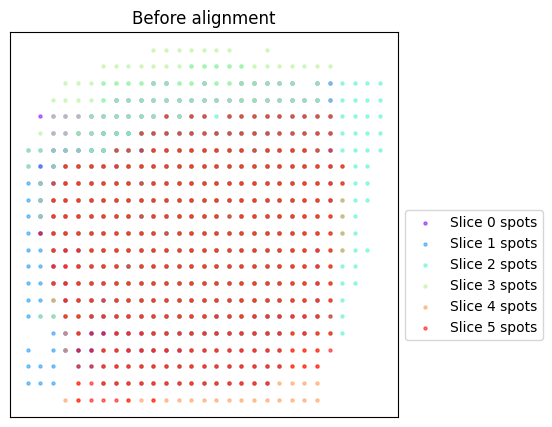

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


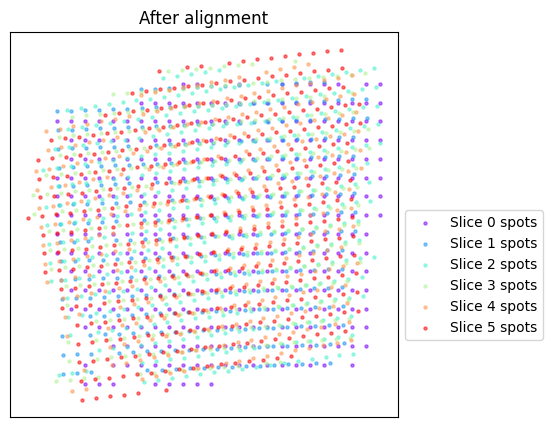

In [4]:
adata_st_list = utils.align_spots(adata_st_list_raw,
                                           data_type="ST",
                                           coor_key="loc_use",
                                           plot=True)

In [5]:
adata_st, adata_basis = utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref_col="celltype_minor",
                                                  sample_col="Patient",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=[16] * 5,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)



Finding highly variable genes...
4530 highly variable genes selected.
Calculate basis for deconvolution...
5 batches are used for computing the basis vector of cell type <B cells Memory>.
5 batches are used for computing the basis vector of cell type <CAFs MSC iCAF-like>.
5 batches are used for computing the basis vector of cell type <CAFs myCAF-like>.
3 batches are used for computing the basis vector of cell type <Cancer Her2 SC>.
5 batches are used for computing the basis vector of cell type <DCs>.
5 batches are used for computing the basis vector of cell type <Endothelial ACKR1>.
5 batches are used for computing the basis vector of cell type <Endothelial CXCL12>.
4 batches are used for computing the basis vector of cell type <Endothelial RGS5>.
2 batches are used for computing the basis vector of cell type <Luminal Progenitors>.
5 batches are used for computing the basis vector of cell type <Macrophage>.
2 batches are used for computing the basis vector of cell type <Mature Luminal>

In [6]:
slice_idx = list(adata_st.obs["slice"].astype(str).unique())
from SINTER3D.predict_selector import auto_select_and_train 
model = auto_select_and_train(
    adata_st_list,
    adata_st,
    adata_basis,
    slice_idx=slice_idx,
    selector_path='/home/lishenghe/SINTER3D/model_selector.pkl',
    config='/home/lishenghe/SINTER3D/SINTER3D/config/her2.json',
)

[特征] n_slices=6, expr_complexity=0.193227
🎯 数据驱动选择模型: COMPLEX
📄 Config parameters loaded: {'hidden_dims': [512, 128], 'slice_emb_dim': 16, 'coef_fe': 0.1, 'training_steps': 5000, 'lr': 0.001, 'seed': 2025, 'patience': 200, 'lambda_dice': 0.7, 'alpha_reg': 0.1, 'mid_channel': 200, 'save_path': './results_her2', 'use_type': 'train', 'normalize': 100, 'beta_coord': 0.6}

✅ Final parameters used in Model:
  hidden_dims: [512, 128]
  slice_emb_dim: 16
  coef_fe: 0.1
  training_steps: 5000
  lr: 0.001
  seed: 2025
  patience: 200
  lambda_dice: 0.7
  alpha_reg: 0.1
  mid_channel: 200
  save_path: ./results_her2
  use_type: train
  normalize: 100
  beta_coord: 0.6

随机种子已设置为: 2025


  0%|          | 12/5000 [00:00<01:26, 57.48it/s]

[Step 0] Loss=21339.912109 | CoordLoss=1.081363 | Best=inf


 20%|██        | 1006/5000 [00:16<01:15, 52.98it/s]

[Step 1000] Loss=1421.908691 | CoordLoss=50.294960 | Best=1427.040283


 40%|████      | 2011/5000 [00:33<00:45, 65.49it/s]

[Step 2000] Loss=-1842.275757 | CoordLoss=47.368298 | Best=-1829.279785


 60%|██████    | 3006/5000 [00:50<00:37, 53.47it/s]

[Step 3000] Loss=-2874.762695 | CoordLoss=43.012112 | Best=-2874.089600


 80%|████████  | 4007/5000 [01:05<00:15, 63.44it/s]

[Step 4000] Loss=-3312.682861 | CoordLoss=42.310684 | Best=-3312.327637


100%|██████████| 5000/5000 [01:21<00:00, 61.54it/s]

✅ Loaded best model state from training.


In [7]:
from SINTER3D.cluster import clustering
output_path='/home/lishenghe/SINTER3D/result_her2/'
result = model.eval(adata_st, save=True, output_path=output_path)
clustering(model.adata_st, n_clusters=6, radius=50, key='latent', method='mclust', refinement=False)


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [8]:
# 保存聚类
import pandas as pd

domain_series = adata_st.obs["domain"]
domain_df = domain_series.to_frame()

domain_df.to_csv("/home/lishenghe/SINTER3D/result_her2/cluster_3D.csv")


In [9]:
# 保存坐标
import pandas as pd

coords = adata_st.obsm["3D_coor"]
coords_df = pd.DataFrame(
    coords,
    index=adata_st.obs.index,        # 行索引：每个 spot 的 ID
    columns=["x", "y", "z"]       # 列名：坐标
)

coords_df.to_csv("/home/lishenghe/SINTER3D/result_her2/3D_coordinates.csv")



In [ ]:
result = sc.concat(result, axis=0, label="batch", keys=[f"slice{i}" for i in range(len(result))])
import re

# 清理索引名称，只保留第一个 -sliceX
def clean_slice_name(name):
    """只保留第一个 -sliceX 标识"""
    # 匹配第一个 -slice 后面跟数字
    match = re.search(r'^(.*?-slice\d+)', name)
    if match:
        return match.group(1)
    return name

result.obs_names = [clean_slice_name(name) for name in result.obs_names]

In [24]:
# 根据 batch 列分割
result = []
unique_batches = adata_merged.obs['slice'].unique()

for batch_id in sorted(unique_batches):
    adata_slice = adata_merged[adata_merged.obs['slice'] == batch_id].copy()
    result.append(adata_slice)

print(f"✅ 分割成 {len(result)} 个切片")


✅ 分割成 6 个切片


In [25]:
result

[AnnData object with n_obs × n_vars = 346 × 4530
     obs: 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'selected', 'array_row', 'array_col', 'st_sample', 'annotation', 'slice', 'batch', 'library_size', 'B cells Memory', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Cancer Her2 SC', 'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial RGS5', 'Luminal Progenitors', 'Macrophage', 'Mature Luminal', 'Monocyte', 'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated', 'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells CD8+'
     obsm: 'spatial', 'loc_use', 'spatial_aligned', 'count', '3D_coor', 'latent',
 AnnData object with n_obs × n_vars = 325 × 4530
     obs: 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'selected', 'array_row', 'array_col', 'st_sample', 'annotation', 'slice', 'batch', 'library_size', 'B cells Memory', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Cancer Her2 SC', 'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial RGS5', 'Luminal Proge

In [26]:
for i in range(len(result)):
    # 添加 domain 标签
    result[i].obs["domain"] = model.adata_st.obs.loc[result[i].obs_names, "domain"]

fitting ...
  |======================================================================| 100%


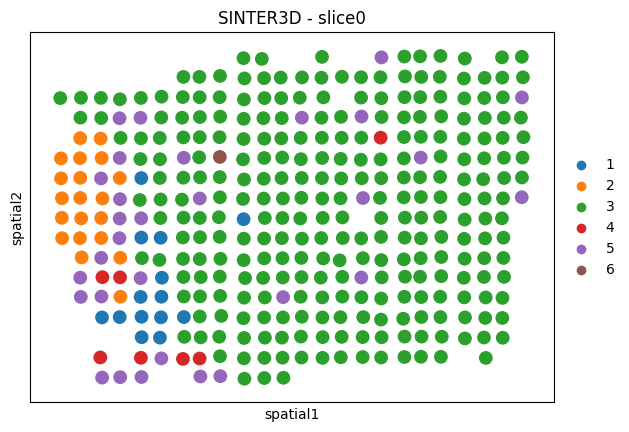

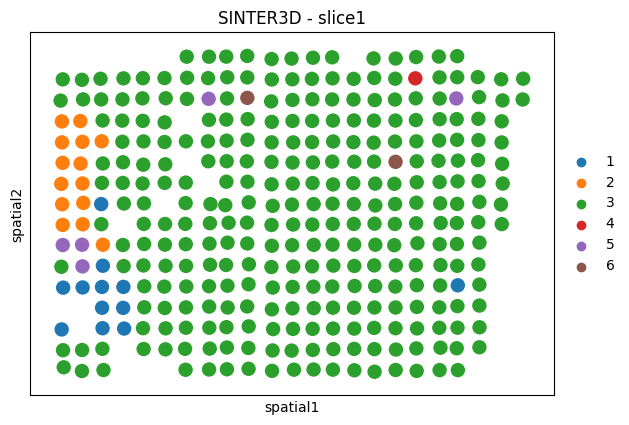

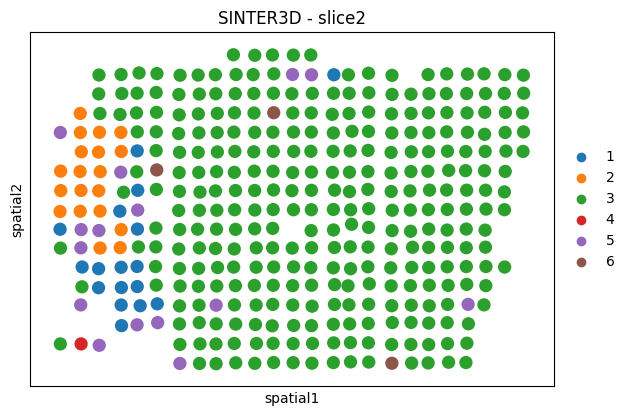

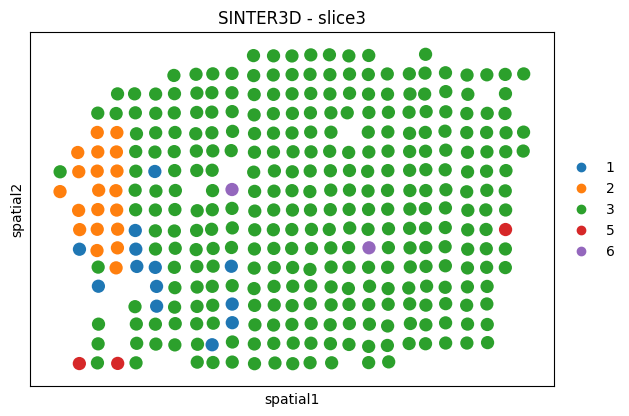

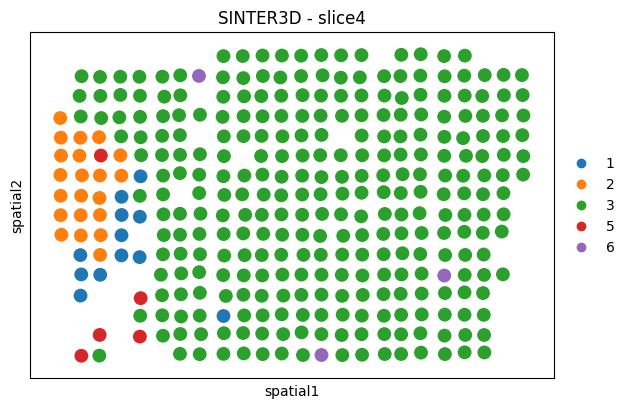

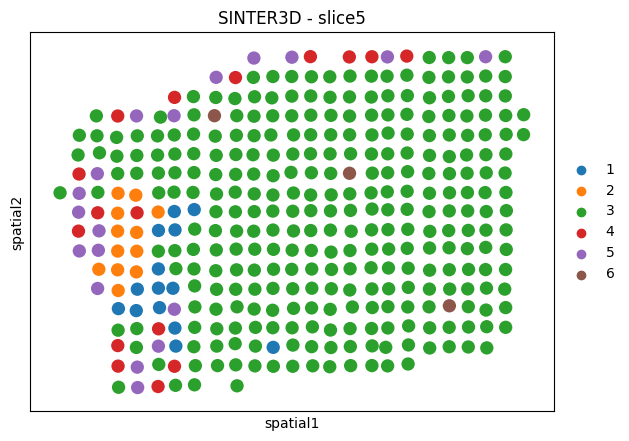

In [17]:
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import scanpy as sc

from SINTER3D.cluster import clustering

# 1️⃣ 复制一份 AnnData
output_path='/home/lishenghe/SINTER3D/result_her2/'
result = model.eval(adata_st, save=True, output_path=output_path)
adata_original = model.adata_st.copy()  # 保存原始副本用于每次迭代
   
clustering(adata_original, n_clusters=6, radius=50, key='latent', method='mclust', refinement=False)

for i in range(6):
    # 2️⃣ 每次循环都从原始数据复制并筛选出 slicei
    adata_first = adata_original[adata_original.obs_names.str.contains(f"slice{i}")].copy()

    # 绘制空间分布图
    sc.pl.spatial(
        adata_first,
        color=["domain"],  # 假设聚类结果存储在'domain'中
        title=[f"SINTER3D - slice{i}"],
        spot_size=150,
        show=False,
    )

    plt.tight_layout()
    plt.show()

随机种子已设置为: 2025
fitting ...
  |======================================================================| 100%
Slice0 ARI: 0.6521


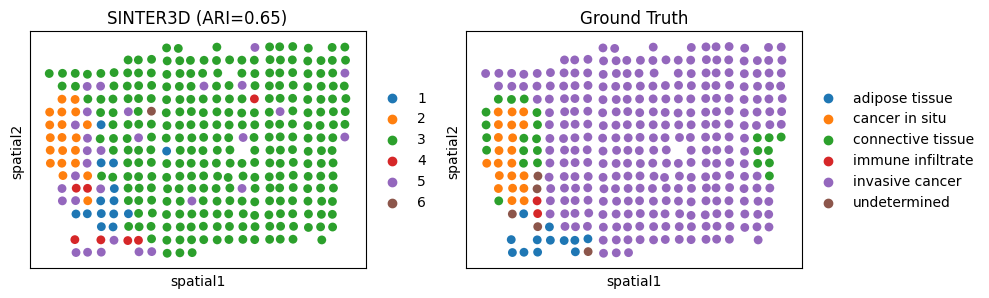

In [11]:
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import scanpy as sc

from SINTER3D.cluster import clustering
from SINTER3D.utils import set_seed

set_seed(2025)
# 1️⃣ 复制一份 AnnData
result = model.eval(adata_st, save=None, output_path='')
adata_first = model.adata_st.copy()
# 4️⃣ 进行聚类
clustering(adata_first, n_clusters=6, radius=50, key='latent', method='mclust', refinement=False)
# 2️⃣ 筛选出 slice0（第一张切片）
adata_first = adata_first[adata_first.obs_names.str.contains("slice0")].copy()

# 5️⃣ 计算 ARI
ari = adjusted_rand_score(adata_first.obs["annotation"], adata_first.obs["domain"])
print(f"Slice0 ARI: {ari:.4f}")

# 6️⃣ 绘图（1行2列）
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.spatial(
    adata_first,
    color=["domain"],
    title=[f"SINTER3D (ARI={ari:.2f})"],
    spot_size=150,
    show=False,
    ax=axes[0]
)

sc.pl.spatial(
    adata_first,
    color=["annotation"],
    title=["Ground Truth"],
    spot_size=150,
    show=False,
    ax=axes[1]
)

plt.tight_layout()
plt.show()


In [22]:
adata_original

AnnData object with n_obs × n_vars = 2065 × 4530
    obs: 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'selected', 'array_row', 'array_col', 'st_sample', 'annotation', 'slice', 'batch', 'library_size', 'mclust', 'domain'
    uns: 'log1p'
    obsm: 'spatial', 'loc_use', 'spatial_aligned', 'count', '3D_coor', 'latent', 'emb_pca'

In [28]:
import scanpy as sc
import pandas as pd
import numpy as np

def find_markers_for_selected_slices(result, selected_slice_ids, min_spots=5, save_dir=None):
    """
    对筛选后的切片进行差异基因分析
    
    参数:
    - result: 所有切片的列表
    - selected_slice_ids: 你手动筛选的切片ID列表，例如 [0, 2, 5]
    - min_spots: domain最少spots数阈值
    - save_dir: 结果保存路径
    """
    all_markers = {}  # 保存所有切片的marker基因
    
    for slice_id in selected_slice_ids:
        adata = result[slice_id].copy()
        
        print(f"\n{'='*70}")
        print(f"🔬 正在分析 Slice {slice_id}")
        print(f"{'='*70}")
        print(f"Spots数: {adata.n_obs}, 基因数: {adata.n_vars}")
        
        # 查看domain分布
        domain_counts = adata.obs['domain'].value_counts().sort_index()
        print(f"\nDomain分布:")
        for domain, count in domain_counts.items():
            status = "✓" if count >= min_spots else "✗"
            print(f"  Domain {domain}: {count} spots {status}")
        
        # 过滤小domain
        valid_domains = domain_counts[domain_counts >= min_spots].index.tolist()
        
        if len(valid_domains) < 2:
            print(f"⚠️  警告: 有效domain数<2，跳过此切片")
            continue
        
        # 只保留有效domain的数据
        adata_filtered = adata[adata.obs['domain'].isin(valid_domains)].copy()
        print(f"\n保留 {len(valid_domains)} 个有效domains进行分析")
        
        # 数据预处理（如果还没做）
        if 'log1p' not in adata_filtered.uns:
            print("正在进行数据标准化...")
            sc.pp.normalize_total(adata_filtered, target_sum=1e4)
            sc.pp.log1p(adata_filtered)
        
        # 差异基因分析
        print("\n🔍 正在进行差异分析 (Wilcoxon秩和检验)...")
        sc.tl.rank_genes_groups(
            adata_filtered,
            groupby='domain',
            method='wilcoxon',
            key_added='domain_markers',
            use_raw=False,
            pts=True  # 计算每个组中表达该基因的细胞比例
        )
        
        # 提取每个domain的marker基因
        markers_dict = {}
        
        for domain in valid_domains:
            markers_df = sc.get.rank_genes_groups_df(
                adata_filtered,
                group=str(domain),
                key='domain_markers'
            )
            
            # 筛选标准:
            # 1. 校正后p值 < 0.05
            # 2. log2FC > 0.5 (表达量提高至少1.4倍)
            # 3. 在该domain中至少25%的spots表达
            sig_markers = markers_df[
                (markers_df['pvals_adj'] < 0.05) & 
                (markers_df['logfoldchanges'] > 0.5)
            ].copy()
            
            # 按logFC排序
            sig_markers = sig_markers.sort_values('logfoldchanges', ascending=False)
            
            markers_dict[domain] = sig_markers
            
            print(f"\n  Domain {domain}:")
            print(f"    显著上调基因: {len(sig_markers)}")
            
            if len(sig_markers) > 0:
                top5 = sig_markers.head(5)
                print(f"    Top 5基因:")
                for idx, row in top5.iterrows():
                    print(f"      {row['names']}: logFC={row['logfoldchanges']:.2f}, p={row['pvals_adj']:.2e}")
        
        # 保存此切片的结果
        all_markers[slice_id] = {
            'adata': adata_filtered,
            'markers': markers_dict,
            'valid_domains': valid_domains
        }
        
        # 保存到文件
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            
            # 保存所有domain的marker基因到一个Excel文件
            with pd.ExcelWriter(f"{save_dir}/slice_{slice_id}_markers.xlsx") as writer:
                for domain, markers in markers_dict.items():
                    markers.to_excel(writer, sheet_name=f'Domain_{domain}', index=False)
            
            print(f"\n✓ Marker基因已保存到: {save_dir}/slice_{slice_id}_markers.xlsx")
    
    return all_markers


# ========== 使用示例 ==========

# 1. 定义你筛选的切片ID
selected_slices = [0,1,2,3,4,5]  

# 2. 运行分析
save_path = "/home/lishenghe/SINTER3D/result_her2/marker_genes/"

markers_results = find_markers_for_selected_slices(
    result=result,
    selected_slice_ids=selected_slices,
    min_spots=5,
    save_dir=save_path
)

# 3. 查看整体结果
print(f"\n{'='*70}")
print("📊 分析汇总")
print(f"{'='*70}")

for slice_id, data in markers_results.items():
    n_domains = len(data['valid_domains'])
    total_markers = sum(len(m) for m in data['markers'].values())
    print(f"\nSlice {slice_id}:")
    print(f"  有效domains: {n_domains}")
    print(f"  总marker基因数: {total_markers}")
    
    for domain in data['valid_domains']:
        n_genes = len(data['markers'][domain])
        print(f"    Domain {domain}: {n_genes} genes")



🔬 正在分析 Slice 0
Spots数: 346, 基因数: 4530

Domain分布:
  Domain 1: 14 spots ✓
  Domain 2: 20 spots ✓
  Domain 3: 274 spots ✓
  Domain 4: 7 spots ✓
  Domain 5: 30 spots ✓
  Domain 6: 1 spots ✗

保留 5 个有效domains进行分析
正在进行数据标准化...

🔍 正在进行差异分析 (Wilcoxon秩和检验)...

  Domain 1:
    显著上调基因: 11
    Top 5基因:
      IGHG3: logFC=5.06, p=5.94e-04
      IGHM: logFC=4.18, p=1.82e-02
      HLA-DPB1: logFC=4.11, p=6.95e-03
      IGHA1: logFC=3.92, p=1.16e-03
      C3: logFC=3.62, p=7.55e-04

  Domain 2:
    显著上调基因: 81
    Top 5基因:
      SUSD2: logFC=5.12, p=9.46e-05
      AREG: logFC=5.03, p=5.21e-04
      TFF1: logFC=4.98, p=1.15e-06
      PPP1R1B: logFC=4.85, p=2.17e-04
      KRT17: logFC=4.84, p=7.65e-06

  Domain 3:
    显著上调基因: 209
    Top 5基因:
      SFXN1: logFC=3.45, p=5.42e-03
      SCARB2: logFC=2.83, p=1.90e-05
      GSTO2: logFC=2.73, p=1.54e-03
      PKIB: logFC=2.54, p=2.03e-04
      ELF1: logFC=2.45, p=4.94e-02

  Domain 4:
    显著上调基因: 17
    Top 5基因:
      EIF4G1: logFC=1.22, p=7.37e-03
      CTS

In [29]:
#GO
import gseapy as gp
from gseapy import Msigdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
def perform_go_enrichment_single_domain(gene_list, organism='human', max_genes=500):
    """
    对单个domain的基因列表进行GO富集分析
    
    参数:
    - gene_list: 基因列表
    - organism: 'human' 或 'mouse'
    - max_genes: 最多使用前N个基因（避免基因太多导致不够特异）
    
    返回:
    - 富集结果DataFrame
    """
    if len(gene_list) == 0:
        print("    ⚠️ 基因列表为空，跳过")
        return None
    
    # 如果基因太多，只取logFC最高的top基因
    if len(gene_list) > max_genes:
        gene_list = gene_list[:max_genes]
        print(f"    使用top {max_genes}个基因进行富集")
    
    print(f"    正在富集 {len(gene_list)} 个基因...")
    
    try:
        # GO Biological Process
        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets='GO_Biological_Process_2023',
            organism='Human' if organism == 'human' else 'Mouse',
            outdir=None,
            cutoff=0.05
        )
        
        results = enr.results
        
        if len(results) > 0:
            print(f"    ✓ 找到 {len(results)} 个显著富集的GO terms (p<0.05)")
            return results
        else:
            print(f"    ⚠️ 未找到显著富集的GO terms")
            return None
            
    except Exception as e:
        print(f"    ✗ 富集分析失败: {e}")
        return None


def enrich_all_domains_single_slice(markers_dict, slice_id, organism='human'):
    """
    对一个切片的所有domain进行GO富集
    
    参数:
    - markers_dict: 该切片的marker基因字典 {domain: DataFrame}
    - slice_id: 切片ID
    - organism: 物种
    
    返回:
    - enrichment_results: {domain: GO富集结果DataFrame}
    """
    print(f"\n{'='*70}")
    print(f"🔬 Slice {slice_id} - GO富集分析")
    print(f"{'='*70}")
    
    enrichment_results = {}
    
    for domain, markers_df in markers_dict.items():
        print(f"\n  Domain {domain} ({len(markers_df)} marker genes):")
        
        if len(markers_df) < 3:
            print(f"    ⚠️ 基因数<5，跳过富集分析")
            continue
        
        # 提取基因列表（已按logFC排序）
        gene_list = markers_df['names'].tolist()
        
        # 执行富集
        enr_result = perform_go_enrichment_single_domain(
            gene_list, 
            organism=organism,
            max_genes=300  # 最多用前300个基因
        )
        
        if enr_result is not None and len(enr_result) > 0:
            enrichment_results[domain] = enr_result
    
    return enrichment_results

# 使用之前保存的markers_results
all_go_results = {}

for slice_id, data in markers_results.items():
    # 执行GO富集
    go_results = enrich_all_domains_single_slice(
        markers_dict=data['markers'],
        slice_id=slice_id,
        organism='human'
    )
    
    all_go_results[slice_id] = go_results
    
    print(f"\n  Slice {slice_id} 完成: {len(go_results)} 个domain有富集结果")

print(f"\n{'='*70}")
print("✓ 所有切片GO富集分析完成！")
print(f"{'='*70}")





🔬 Slice 0 - GO富集分析

  Domain 1 (11 marker genes):
    正在富集 11 个基因...
    ✓ 找到 206 个显著富集的GO terms (p<0.05)

  Domain 2 (81 marker genes):
    正在富集 81 个基因...
    ✓ 找到 1032 个显著富集的GO terms (p<0.05)

  Domain 3 (209 marker genes):
    正在富集 209 个基因...
    ✓ 找到 1690 个显著富集的GO terms (p<0.05)

  Domain 4 (17 marker genes):
    正在富集 17 个基因...
    ✓ 找到 232 个显著富集的GO terms (p<0.05)

  Domain 5 (16 marker genes):
    正在富集 16 个基因...
    ✓ 找到 273 个显著富集的GO terms (p<0.05)

  Slice 0 完成: 5 个domain有富集结果

🔬 Slice 1 - GO富集分析

  Domain 1 (29 marker genes):
    正在富集 29 个基因...
    ✓ 找到 489 个显著富集的GO terms (p<0.05)

  Domain 2 (103 marker genes):
    正在富集 103 个基因...
    ✓ 找到 1114 个显著富集的GO terms (p<0.05)

  Domain 3 (116 marker genes):
    正在富集 116 个基因...
    ✓ 找到 1155 个显著富集的GO terms (p<0.05)

  Domain 5 (32 marker genes):
    正在富集 32 个基因...
    ✓ 找到 465 个显著富集的GO terms (p<0.05)

  Slice 1 完成: 4 个domain有富集结果

🔬 Slice 2 - GO富集分析

  Domain 1 (29 marker genes):
    正在富集 29 个基因...
    ✓ 找到 387 个显著富集的GO terms (p<0.05)


In [30]:
#GO保存
def save_go_results_to_excel(all_go_results, markers_results, save_dir):
    """
    将所有GO富集结果保存为Excel文件
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for slice_id, go_results in all_go_results.items():
        if len(go_results) == 0:
            continue
        
        excel_path = f"{save_dir}/slice_{slice_id}_GO_enrichment.xlsx"
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            for domain, enr_df in go_results.items():
                # 只保留最相关的列
                columns_to_save = [
                    'Term', 'Overlap', 'P-value', 'Adjusted P-value',
                    'Odds Ratio', 'Combined Score', 'Genes'
                ]
                save_df = enr_df[columns_to_save].copy()
                
                # 按Adjusted P-value排序
                save_df = save_df.sort_values('Adjusted P-value')
                
                # 保存到sheet
                save_df.to_excel(writer, sheet_name=f'Domain_{domain}', index=False)
        
        print(f"✓ 保存: {excel_path}")
    
    print(f"\n✓ 所有GO富集结果已保存到: {save_dir}")


# 执行保存
save_dir = "/home/lishenghe/SINTER3D/result_her2/GO_enrichment/"
save_go_results_to_excel(all_go_results, markers_results, save_dir)



✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_0_GO_enrichment.xlsx
✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_1_GO_enrichment.xlsx
✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_2_GO_enrichment.xlsx
✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_3_GO_enrichment.xlsx
✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_4_GO_enrichment.xlsx
✓ 保存: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//slice_5_GO_enrichment.xlsx

✓ 所有GO富集结果已保存到: /home/lishenghe/SINTER3D/result_her2/GO_enrichment/


In [31]:
#GO可视化
def plot_go_barplot_per_domain(enr_df, domain, slice_id, top_n=10, save_path=None):
    """
    为单个domain绘制GO富集柱状图
    """
    if enr_df is None or len(enr_df) == 0:
        return
    
    # 选择top N个term
    plot_df = enr_df.head(top_n).copy()
    
    # 计算-log10(adj p-value)
    plot_df['neg_log_p'] = -np.log10(plot_df['Adjusted P-value'])
    
    # 截断过长的term名称
    plot_df['Term_short'] = plot_df['Term'].apply(
        lambda x: x[:60] + '...' if len(x) > 60 else x
    )
    
    # 从Overlap列提取基因数 (格式: "5/100")
    plot_df['gene_count'] = plot_df['Overlap'].apply(
        lambda x: int(x.split('/')[0])
    )
    
    # 排序
    plot_df = plot_df.sort_values('neg_log_p')
    
    # 绘图
    fig, ax = plt.subplots(figsize=(10, max(6, top_n * 0.4)))
    
    # 颜色映射
    colors = plt.cm.Reds(plot_df['neg_log_p'] / plot_df['neg_log_p'].max())
    
    bars = ax.barh(range(len(plot_df)), plot_df['neg_log_p'], color=colors)
    
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df['Term_short'], fontsize=9)
    ax.set_xlabel('-log10(Adjusted P-value)', fontsize=11, fontweight='bold')
    ax.set_title(f'Slice {slice_id} - Domain {domain}\nTop {top_n} GO Terms', 
                 fontsize=13, fontweight='bold')
    
    # 添加基因数标签
    for i, (idx, row) in enumerate(plot_df.iterrows()):
        ax.text(row['neg_log_p'] + 0.5, i, f"n={row['gene_count']}", 
                va='center', fontsize=8, color='darkred')
    
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def visualize_all_go_results(all_go_results, save_dir, top_n=10):
    """
    为所有切片的所有domain生成GO富集柱状图
    """
    plot_dir = f"{save_dir}/barplots/"
    os.makedirs(plot_dir, exist_ok=True)
    
    total_plots = 0
    
    for slice_id, go_results in all_go_results.items():
        print(f"\n绘制 Slice {slice_id} 的GO富集图...")
        
        for domain, enr_df in go_results.items():
            save_path = f"{plot_dir}/slice_{slice_id}_domain_{domain}_GO_barplot.png"
            
            plot_go_barplot_per_domain(
                enr_df, domain, slice_id, 
                top_n=top_n, 
                save_path=save_path
            )
            
            total_plots += 1
            print(f"  ✓ Domain {domain}")
    
    print(f"\n✓ 共生成 {total_plots} 张GO富集柱状图")
    print(f"✓ 保存位置: {plot_dir}")


# 执行可视化
visualize_all_go_results(
    all_go_results, 
    save_dir=save_dir,
    top_n=15  # 每个domain显示top 15 GO terms
)



绘制 Slice 0 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3
  ✓ Domain 4
  ✓ Domain 5

绘制 Slice 1 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3
  ✓ Domain 5

绘制 Slice 2 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3
  ✓ Domain 5

绘制 Slice 3 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3

绘制 Slice 4 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3
  ✓ Domain 5

绘制 Slice 5 的GO富集图...
  ✓ Domain 1
  ✓ Domain 2
  ✓ Domain 3
  ✓ Domain 4
  ✓ Domain 5

✓ 共生成 25 张GO富集柱状图
✓ 保存位置: /home/lishenghe/SINTER3D/result_her2/GO_enrichment//barplots/


In [32]:
#单切片GO可视化
def plot_go_dotplot_slice(go_results, slice_id, top_n=5, save_path=None):
    """
    为单个切片的所有domain绘制GO富集点图
    """
    plot_data = []
    
    for domain, enr_df in go_results.items():
        if enr_df is None or len(enr_df) == 0:
            continue
        
        # 取top N个terms
        top_terms = enr_df.head(top_n)
        
        for _, row in top_terms.iterrows():
            # 提取基因数
            gene_count = int(row['Overlap'].split('/')[0])
            
            plot_data.append({
                'Domain': f"D{domain}",
                'Term': row['Term'][:50],  # 截断过长名称
                'Adj_Pvalue': row['Adjusted P-value'],
                'Gene_Count': gene_count,
                'neg_log_p': -np.log10(row['Adjusted P-value'])
            })
    
    if len(plot_data) == 0:
        print(f"  ⚠️ Slice {slice_id} 没有数据可绘制")
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # 绘图
    fig, ax = plt.subplots(figsize=(12, max(8, len(plot_df) * 0.15)))
    
    # 创建散点图
    scatter = ax.scatter(
        plot_df['Domain'],
        plot_df['Term'],
        s=plot_df['Gene_Count'] * 30,
        c=plot_df['neg_log_p'],
        cmap='Reds',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Domain', fontsize=12, fontweight='bold')
    ax.set_ylabel('GO Term', fontsize=12, fontweight='bold')
    ax.set_title(f'Slice {slice_id} - GO Enrichment Across Domains\n(Top {top_n} per domain)', 
                 fontsize=14, fontweight='bold')
    
    # 旋转x轴标签
    plt.xticks(rotation=0, ha='center')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('-log10(Adj P-value)', rotation=270, labelpad=20, fontweight='bold')
    
    # 添加图例（点大小）
    sizes = [5, 10, 20]
    labels = ['5', '10', '20']
    legend_points = [
        plt.scatter([], [], s=s*30, c='gray', alpha=0.7, edgecolors='black') 
        for s in sizes
    ]
    ax.legend(legend_points, labels, title='Gene Count', 
              loc='upper left', bbox_to_anchor=(1.15, 1), frameon=True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def create_all_dotplots(all_go_results, save_dir, top_n=5):
    """
    为所有切片创建点图
    """
    dotplot_dir = f"{save_dir}/dotplots/"
    os.makedirs(dotplot_dir, exist_ok=True)
    
    for slice_id, go_results in all_go_results.items():
        print(f"绘制 Slice {slice_id} 的点图...")
        
        save_path = f"{dotplot_dir}/slice_{slice_id}_GO_dotplot.png"
        plot_go_dotplot_slice(go_results, slice_id, top_n=top_n, save_path=save_path)
    
    print(f"\n✓ 所有点图已保存到: {dotplot_dir}")


# 执行点图绘制
create_all_dotplots(all_go_results, save_dir='/home/lishenghe/SINTER3D/result_her2/', top_n=5)


绘制 Slice 0 的点图...
绘制 Slice 1 的点图...
绘制 Slice 2 的点图...
绘制 Slice 3 的点图...
绘制 Slice 4 的点图...
绘制 Slice 5 的点图...

✓ 所有点图已保存到: /home/lishenghe/SINTER3D/result_her2//dotplots/


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def assign_major_celltype(adata):
    """为每个细胞分配主要细胞类型"""
    celltype_cols = ['B cells Memory', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 
                     'Cancer Her2 SC', 'DCs', 'Endothelial ACKR1', 
                     'Endothelial CXCL12', 'Endothelial RGS5', 'Luminal Progenitors', 
                     'Macrophage', 'Mature Luminal', 'Monocyte', 'Myoepithelial', 
                     'NK cells', 'NKT cells', 'PVL Differentiated', 'PVL Immature', 
                     'Plasmablasts', 'T cells CD4+', 'T cells CD8+']
    
    existing_cols = [col for col in celltype_cols if col in adata.obs.columns]
    
    if len(existing_cols) == 0:
        return adata
    
    celltype_scores = adata.obs[existing_cols].values
    max_indices = celltype_scores.argmax(axis=1)
    adata.obs['major_celltype'] = [existing_cols[i] for i in max_indices]
    
    return adata


def plot_all_slices_combined_dotplot(result_list, save_path=None):
    """
    将所有切片的数据合并，对相同的Domain-CellType组合求和
    """
    print("\n" + "="*60)
    print("合并所有切片数据...")
    
    all_plot_data = []
    
    # ========== 第一步：收集所有切片的原始统计数据 ==========
    for i, adata in enumerate(result_list):
        slice_id = f"S{i+1}"
        
        if 'domain' not in adata.obs.columns:
            print(f"  ⚠️ {slice_id} 缺少domain列，跳过")
            continue
        
        adata = assign_major_celltype(adata)
        
        # 统计当前切片的数据
        crosstab = pd.crosstab(adata.obs['domain'], adata.obs['major_celltype'])
        
        for domain in crosstab.index:
            for celltype in crosstab.columns:
                count = crosstab.loc[domain, celltype]
                
                if count > 0:
                    all_plot_data.append({
                        'Domain': domain,  # 保留原始domain值
                        'CellType': celltype,
                        'Count': count
                    })
        
        print(f"  ✓ {slice_id}: {len(crosstab)} domains, {len(crosstab.columns)} cell types")
    
    if len(all_plot_data) == 0:
        print("  ❌ 没有可绘制的数据")
        return
    
    # ========== 第二步：按 Domain-CellType 分组求和 ==========
    plot_df = pd.DataFrame(all_plot_data)
    
    # 关键：对相同的 Domain-CellType 组合的 Count 求和
    plot_df_agg = plot_df.groupby(['Domain', 'CellType'], as_index=False).agg({
        'Count': 'sum'
    })
    
    # ========== 新增：按Domain值排序并创建Cluster标签 ==========
    # 获取所有唯一的domain值并排序
    unique_domains = sorted(plot_df_agg['Domain'].unique())
    
    # 创建domain到Cluster标签的映射字典
    domain_to_cluster = {domain: f'Cluster{i+1}' for i, domain in enumerate(unique_domains)}
    
    # 应用映射
    plot_df_agg['Cluster'] = plot_df_agg['Domain'].map(domain_to_cluster)
    
    print(f"\nDomain到Cluster的映射:")
    for domain, cluster in domain_to_cluster.items():
        print(f"  {domain} -> {cluster}")
    
    # ========== 第三步：计算富集倍数 ==========
    total = plot_df_agg['Count'].sum()
    
    # 使用原始Domain计算（保证统计正确性）
    domain_totals = plot_df_agg.groupby('Domain')['Count'].sum()
    celltype_totals = plot_df_agg.groupby('CellType')['Count'].sum()
    
    enrichments = []
    for _, row in plot_df_agg.iterrows():
        domain = row['Domain']
        celltype = row['CellType']
        observed = row['Count']
        
        expected = (domain_totals[domain] * celltype_totals[celltype]) / total
        enrichment = observed / expected if expected > 0 else 0
        enrichments.append(np.log2(enrichment + 0.01))
    
    plot_df_agg['log2_Enrichment'] = enrichments
    
    print(f"\n合并完成:")
    print(f"  原始数据点: {len(plot_df)} (来自多个切片)")
    print(f"  合并后数据点: {len(plot_df_agg)} (每个Domain-CellType组合一个点)")
    print(f"  Cluster数: {plot_df_agg['Cluster'].nunique()}")
    print(f"  细胞类型数: {plot_df_agg['CellType'].nunique()}")
    
    # ========== 绘图 ==========
    n_celltypes = len(plot_df_agg['CellType'].unique())
    n_clusters = len(plot_df_agg['Cluster'].unique())
    
    fig, ax = plt.subplots(figsize=(max(16, n_clusters * 0.8), max(12, n_celltypes * 0.6)))
    
    # 绘制散点图 - 使用Cluster标签
    scatter = ax.scatter(
        plot_df_agg['Cluster'],  # 改为使用Cluster标签
        plot_df_agg['CellType'],
        s=plot_df_agg['Count'] * 0.8,
        c=plot_df_agg['log2_Enrichment'],
        cmap='RdBu_r',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        vmin=-2, vmax=2
    )
    
    ax.set_xlabel('Spatial Domain', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cell Type', fontsize=14, fontweight='bold')
    
    # 确保Cluster按顺序显示
    cluster_order = [f'Cluster{i+1}' for i in range(n_clusters)]
    ax.set_xticks(range(len(cluster_order)))
    ax.set_xticklabels(cluster_order, rotation=0, ha='center', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=13, fontweight='bold')
    
    # 颜色条
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('log2(Enrichment)', rotation=270, labelpad=25, fontweight='bold', fontsize=12)
    
    # 图例(点大小)
    count_values = plot_df_agg['Count'].quantile([0.25, 0.5, 0.75]).astype(int)
    legend_points = [
        plt.scatter([], [], s=c*0.8, c='gray', alpha=0.7, edgecolors='black', linewidth=0.5) 
        for c in count_values
    ]
    ax.legend(legend_points, [str(c) for c in count_values], 
              title='Total Cell Count', loc='upper left', 
              bbox_to_anchor=(1.12, 1), frameon=True, fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.close()
        print(f"\n✅ 合并图已保存: {save_path}")
    else:
        plt.show()


# ========== 执行 ==========
save_path = '/home/lishenghe/SINTER3D/result_her2/all_slices_combined_dotplot.png'

plot_all_slices_combined_dotplot(
    result_list=result,
    save_path=save_path
)



合并所有切片数据...
  ✓ S1: 6 domains, 2 cell types
  ✓ S2: 6 domains, 2 cell types
  ✓ S3: 6 domains, 2 cell types
  ✓ S4: 5 domains, 3 cell types
  ✓ S5: 5 domains, 2 cell types
  ✓ S6: 6 domains, 2 cell types

Domain到Cluster的映射:
  1 -> Cluster1
  2 -> Cluster2
  3 -> Cluster3
  4 -> Cluster4
  5 -> Cluster5
  6 -> Cluster6

合并完成:
  原始数据点: 38 (来自多个切片)
  合并后数据点: 8 (每个Domain-CellType组合一个点)
  Cluster数: 6
  细胞类型数: 3

✅ 合并图已保存: /home/lishenghe/SINTER3D/result_her2/all_slices_combined_dotplot.png


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ========== 步骤1: 为每个细胞分配主要细胞类型 ==========
def assign_major_celltype(adata):
    """
    根据每个细胞在各细胞类型列的值，分配主要细胞类型
    """
    celltype_cols = ['brain', 'epidermis', 'foregut / hindgut / anal pad', 
                     'midgut', 'muscle', 'plasmatocytes', 'somatic muscle', 
                     'tracheal system', 'ubiquitous']
    
    # 检查这些列是否都存在
    existing_cols = [col for col in celltype_cols if col in adata.obs.columns]
    
    if len(existing_cols) == 0:
        print("⚠️ 找不到细胞类型列！")
        return adata
    
    # 提取细胞类型得分矩阵
    celltype_scores = adata.obs[existing_cols].values
    
    # 为每个细胞找到得分最高的细胞类型
    max_indices = celltype_scores.argmax(axis=1)
    adata.obs['major_celltype'] = [existing_cols[i] for i in max_indices]
    
    print(f"✓ 已为 {adata.n_obs} 个细胞分配主要细胞类型")
    print(f"  细胞类型分布:\n{adata.obs['major_celltype'].value_counts()}")
    
    return adata


# ========== 步骤2: 绘制点图 ==========
def plot_domain_celltype_dotplot(adata, slice_id, save_path=None):
    """
    绘制域-细胞类型点图
    """
    # 确保已分配细胞类型
    if 'major_celltype' not in adata.obs.columns:
        adata = assign_major_celltype(adata)
    
    # 统计数据
    crosstab = pd.crosstab(adata.obs['domain'], adata.obs['major_celltype'])
    
    # 计算富集倍数
    total = crosstab.sum().sum()
    domain_totals = crosstab.sum(axis=1)
    celltype_totals = crosstab.sum(axis=0)
    
    plot_data = []
    
    for domain in crosstab.index:
        for celltype in crosstab.columns:
            observed = crosstab.loc[domain, celltype]
            expected = (domain_totals[domain] * celltype_totals[celltype]) / total
            enrichment = observed / expected if expected > 0 else 0
            
            if observed > 0:
                plot_data.append({
                    'Domain': f'D{domain}',
                    'CellType': celltype,
                    'Count': observed,
                    'Enrichment': enrichment,
                    'log2_Enrichment': np.log2(enrichment + 0.01)
                })
    
    if len(plot_data) == 0:
        print(f"  ⚠️ Slice {slice_id} 没有数据可绘制")
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # 绘图
    n_celltypes = len(plot_df['CellType'].unique())
    fig, ax = plt.subplots(figsize=(14, max(10, n_celltypes * 0.5)))
    
    scatter = ax.scatter(
        plot_df['Domain'],
        plot_df['CellType'],
        s=plot_df['Count'] * 3,
        c=plot_df['log2_Enrichment'],
        cmap='RdBu_r',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        vmin=-2, vmax=2
    )
    
    ax.set_xlabel('Domain', fontsize=13, fontweight='bold')
    ax.set_ylabel('Cell Type', fontsize=13, fontweight='bold')
    ax.set_title(f'Slice {slice_id} - Cell Type Enrichment in Domains', 
                 fontsize=15, fontweight='bold', pad=20)
    
    plt.xticks(rotation=0, ha='center', fontsize=11)
    plt.yticks(fontsize=10)
    
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('log2(Enrichment)', rotation=270, labelpad=20, fontweight='bold')
    
    if len(plot_df) > 3:
        count_values = plot_df['Count'].quantile([0.25, 0.5, 0.75]).astype(int)
    else:
        count_values = sorted(plot_df['Count'].unique())[:3]
    
    legend_points = [
        plt.scatter([], [], s=c*3, c='gray', alpha=0.7, edgecolors='black') 
        for c in count_values
    ]
    ax.legend(legend_points, [str(c) for c in count_values], 
              title='Cell Count', loc='upper left', 
              bbox_to_anchor=(1.12, 1), frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"  ✓ 已保存: {save_path}")
    else:
        plt.show()


# ========== 步骤3: 批量处理所有切片 ==========
def create_all_domain_celltype_dotplots(result_list, save_dir):
    """
    为result列表中的所有切片创建点图
    """
    plot_dir = f"{save_dir}/domain_celltype_dotplot/"
    os.makedirs(plot_dir, exist_ok=True)
    
    print(f"\n开始绘制 {len(result_list)} 个切片的点图...\n")
    
    for i, adata in enumerate(result_list):
        slice_id = f"slice_{i+1}"
        print(f"{'='*60}")
        print(f"[{i+1}/{len(result_list)}] 处理 {slice_id}...")
        
        # 检查domain列
        if 'domain' not in adata.obs.columns:
            print(f"  ⚠️ {slice_id} 缺少 'domain' 列,跳过")
            continue
        
        # 分配细胞类型
        adata = assign_major_celltype(adata)
        
        save_path = f"{plot_dir}/{slice_id}_domain_celltype_dotplot.png"
        
        try:
            plot_domain_celltype_dotplot(adata, slice_id, save_path=save_path)
        except Exception as e:
            print(f"  ❌ {slice_id} 绘图失败: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"\n{'='*60}")
    print(f"✅ 所有点图已保存到: {plot_dir}")

# ========== 执行 ==========
create_all_domain_celltype_dotplots(
    result_list=result,
    save_dir='/home/lishenghe/SINTER3D/result_her2/'
)



开始绘制 6 个切片的点图...

[1/6] 处理 slice_1...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_1_domain_celltype_dotplot.png
[2/6] 处理 slice_2...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_2_domain_celltype_dotplot.png
[3/6] 处理 slice_3...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_3_domain_celltype_dotplot.png
[4/6] 处理 slice_4...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_4_domain_celltype_dotplot.png
[5/6] 处理 slice_5...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_5_domain_celltype_dotplot.png
[6/6] 处理 slice_6...
⚠️ 找不到细胞类型列！
  ✓ 已保存: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot//slice_6_domain_celltype_dotplot.png

✅ 所有点图已保存到: /home/lishenghe/SINTER3D/result_her2//domain_celltype_dotplot/


In [ ]:
# output_path = "./results_breast_cancer"

# result = model.eval(adata_st_list, save=None, output_path=output_path)